<a href="https://colab.research.google.com/github/PIYUSH-GOYAL1/AssignmentsOfPythonForDataScience/blob/main/Object_Detection_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.6 MB/s eta 0:00:00


In [3]:
import os
import keras
import keras_cv
from PIL import Image
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import numpy as np
import tqdm

import keras_cv
from keras_cv import bounding_box , visualization

Using TensorFlow backend


In [4]:
 os.environ["KERAS_BACKEND"] = "tensorflow"

In [5]:
BATCH_SIZE = 4

In [7]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]

In [8]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [9]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [10]:
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

In [11]:
def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds

In [12]:
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.UZT0UR_4.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.UZT0UR_4.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.UZT0UR_4.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [16]:
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

In [17]:
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [18]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

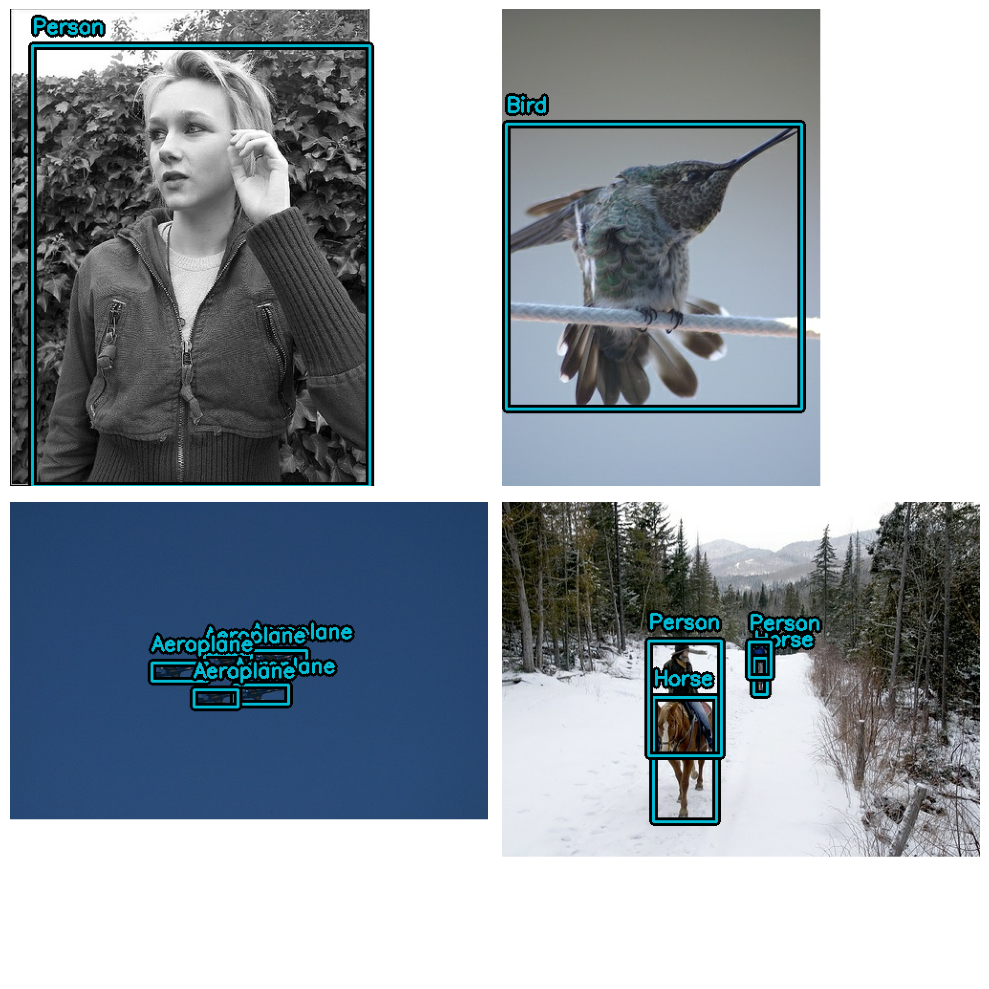

In [22]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

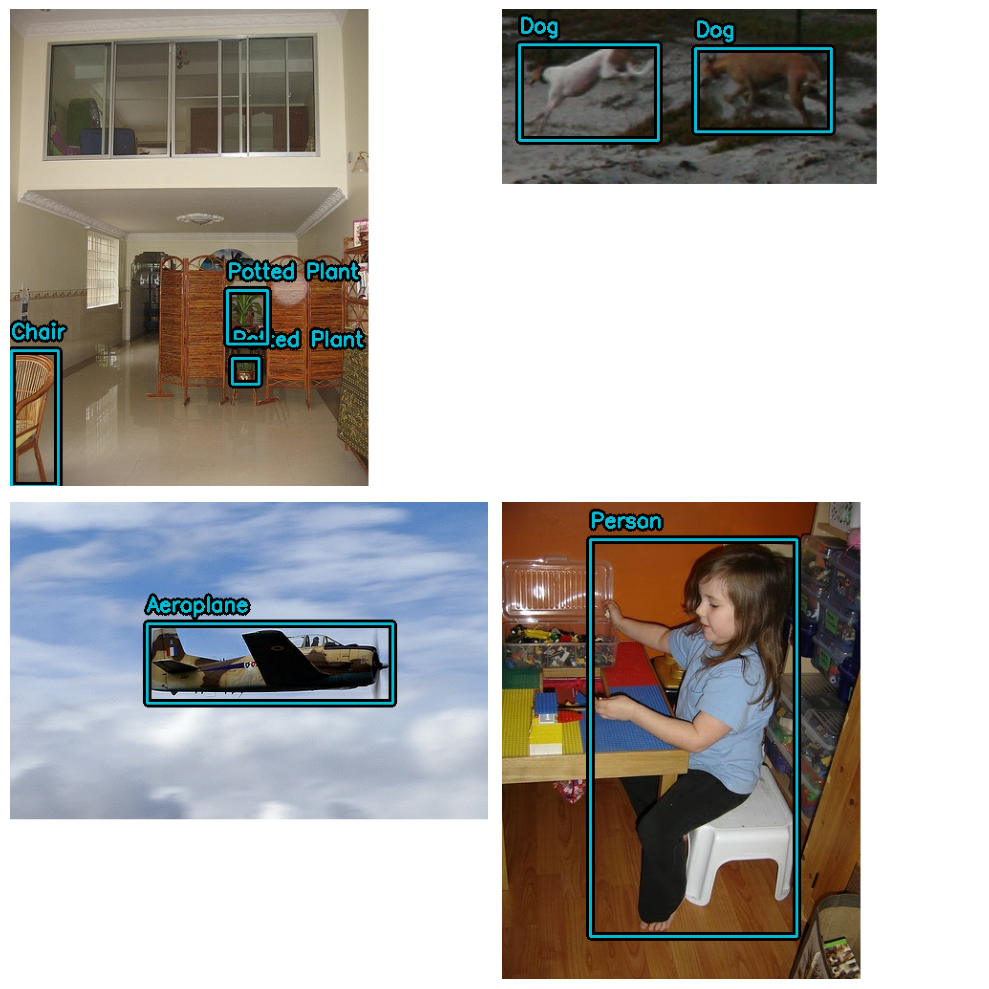

In [24]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
)

In [25]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]

In [26]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

In [27]:
augmenter_fn = create_augmenter_fn(augmenters)

In [28]:
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)

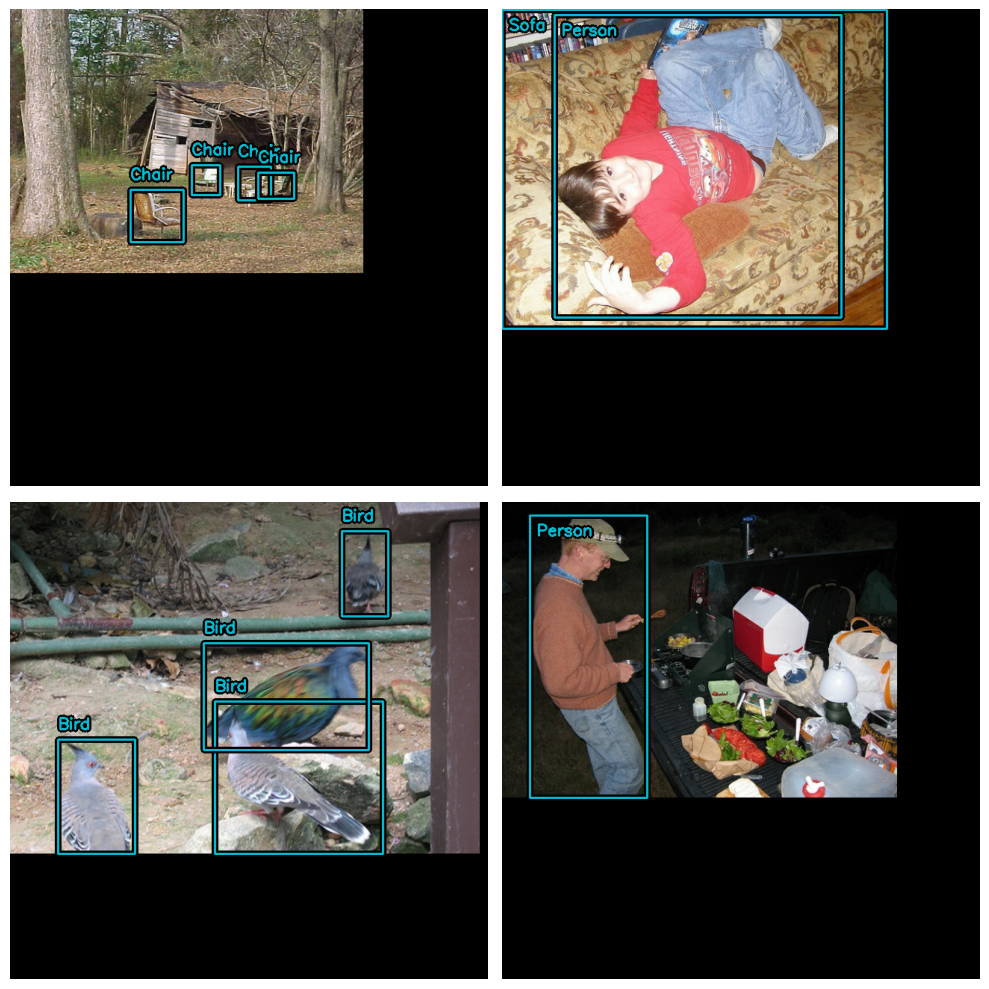

In [30]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [31]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

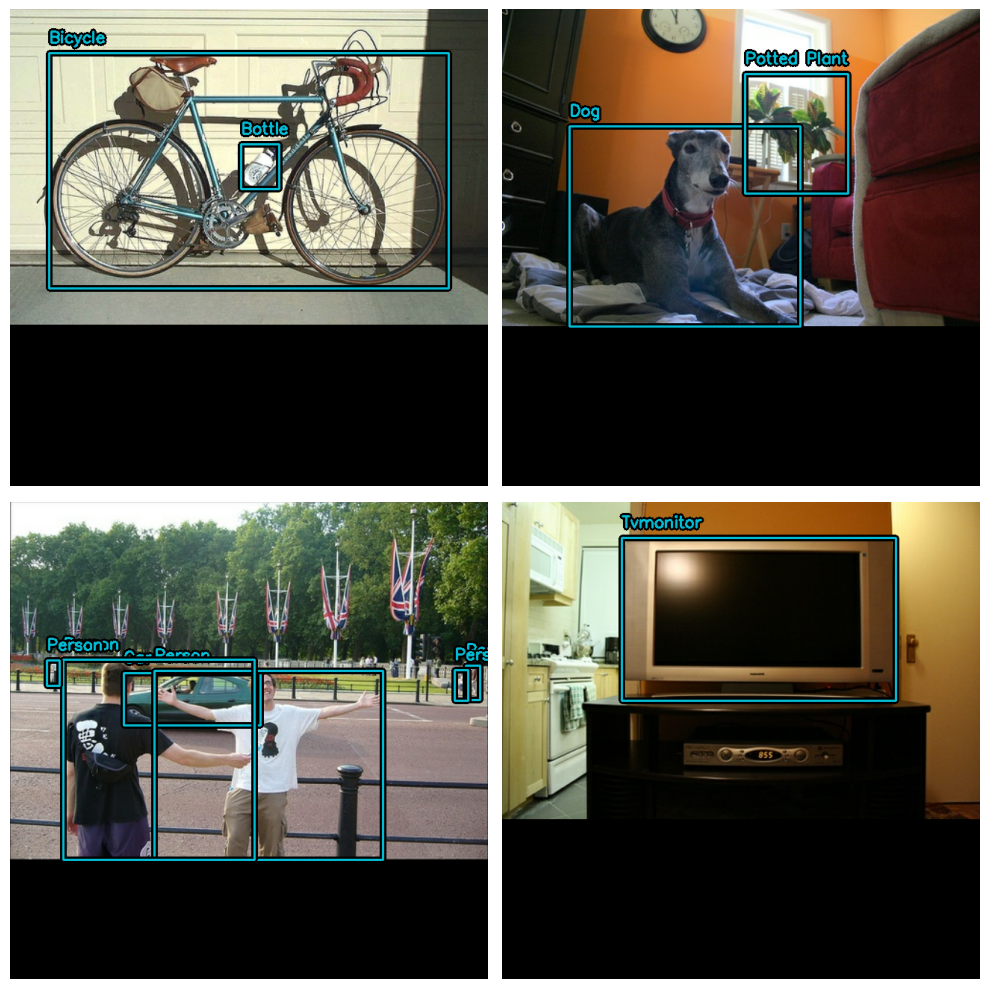

In [32]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)


In [33]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

In [34]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [36]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 435kB/s]
100%|██████████| 99.5M/99.5M [00:02<00:00, 38.7MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [37]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [38]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)


100%|██████████| 777/777 [00:00<00:00, 1.18MB/s]
100%|██████████| 90.3M/90.3M [00:01<00:00, 51.9MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [39]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [41]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [ ]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

 1/20 [>.............................] - ETA: 47:26 - loss: 335.2038 - box_loss: 3.2336 - class_loss: 331.9703